In [1]:
import xarray as xr
import numpy as np
from google.cloud import storage
import fsspec
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr
from pathlib import Path
import ujson
from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scores
import pandas as pd
import seaborn as sns
import eccodes
import cfgrib
import herbie.accessors



In [2]:
sns.set_theme(style='whitegrid',context='talk')

This notebook is designed as an end-to-end implementation of ExtremeWeatherBench for the Pacific Northwest Heatwave which occurred between 2021 June 26, 00z and 2021 June 30, 00z

# Define constants

In [3]:
bounding_box = [-125, -116, 42, 60] # W, E, S, N
temperature_ehe_percentile = 0.85 # Defined as the baseline for a daily min, max, mean, or apparent temperture which is considered an extreme heat event
# 2020 onwards purposefully avoided as recent years were used to train AI models
climatology_min = 1989
climatology_max = 2019

#point obs locations, seatac, bellingham, vancouver, lytton
ksea_coords = (47.44469, -122.31437)
kbli_coords = (48.79269, -122.53753)
cyvr_coords = (49.18303, -123.16823)
cwly_coords = (50.22448, -121.58180)

point_df = pd.DataFrame(
    {
    "longitude": [n[1] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "latitude": [n[0] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "name": ['KSEA', 'KBLI', 'CYVR', 'CWLY']
    }
)

# Define Functions

In [4]:
fs_read = fsspec.filesystem('gcs', anon=False, skip_instance_cache=True)
fs_local = fsspec.filesystem('')  
json_dir = 'assets/json/'
json_list = fs_local.glob(str(json_dir)+'PANG*_.json')
so = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first')

def convert_longitude_to_360(longitude):
    return longitude % 360

def generate_json_from_grap_nc(u,fs, fs_out):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)

        file_split = u.split('/') # seperate file path to create a unique name for each json 
        model = file_split[1].split('_')[0]
        date_string = file_split[-1].split('_')[3]
        outf = f'{json_dir}{model}_{date_string}_.json'
        print(outf)
        with fs_out.open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());

# seasonal aggregation functions for max, min, and mean
def seasonal_subset_max(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.max()

def seasonal_subset_min(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.min()

def seasonal_subset_mean(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.mean()

x:\anaconda3\envs\brightband\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Initialize Dask Cluster

In [5]:
cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit='3GiB',
)
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56961,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:56996,Total threads: 4
Dashboard: http://127.0.0.1:56999/status,Memory: 3.00 GiB
Nanny: tcp://127.0.0.1:56964,


# Begin Data Pull

In [7]:
gcs_client = storage.Client()
bucket = gcs_client.get_bucket('bb-cira-oar-mlwp-data')

x:\anaconda3\envs\brightband\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [8]:
file_list = fs_read.glob('gs://bb-cira-oar-mlwp-data/PANG_v100/2021/**/*.nc')

In [9]:
# for file in file_list:
#     generate_json_from_grap_nc(file,fs_read, fs_local)

# Load in all point source obs, compute 85th percentiles

In [62]:
ksea_event_df = pd.read_csv(f'assets/data/KSEA_event.csv').dropna()
ksea_event_df['valid'] = pd.to_datetime(ksea_event_df['valid'])
ksea_event_df['tmpc'] = ksea_event_df['tmpc'].astype(float)
ksea_event_df = ksea_event_df.set_index('valid')
ksea_event_df = ksea_event_df.resample('h').mean(numeric_only=True)
ksea_event_df = ksea_event_df[['tmpc']]

In [ ]:
ksea_event_df

,tmpc
valid,
2021-06-01 00:00:00,25.56
2021-06-01 01:00:00,24.44
2021-06-01 02:00:00,22.78
2021-06-01 03:00:00,21.11
2021-06-01 04:00:00,20.00
...,...
2021-07-31 19:00:00,23.33
2021-07-31 20:00:00,21.67
2021-07-31 21:00:00,21.67


In [11]:
point_obs_dict = {}
point_obs_dict['KSEA'] = {}
point_obs_dict['KBLI'] = {}
point_obs_dict['CYVR'] = {}
point_obs_dict['CWLY'] = {}

for station in point_obs_dict.items():
    station[1]['data'] = pd.read_csv(f'assets/data/{station[0]}.csv').dropna()
    station[1]['data']['valid'] = pd.to_datetime(station[1]['data']['valid'])
    station[1]['data']['tmpc'] = station[1]['data']['tmpc'].astype(float)
    station[1]['data'] = station[1]['data'].set_index('valid')
    station[1]['data'] = station[1]['data'].resample('h').mean(numeric_only=True)
    subset_summer_df = station[1]['data']['tmpc'][station[1]['data']['tmpc'].index.month.isin([6,7,8])]
    station[1]['max_temp_85th_percentile'] = np.nanpercentile(subset_summer_df.resample('D').max(),85)
    station[1]['min_temp_85th_percentile'] = np.nanpercentile(subset_summer_df.resample('D').min(),85)
    station[1]['mean_temp_85th_percentile'] = np.nanpercentile(subset_summer_df.resample('D').mean(),85)

# Load in KSEA Temp Obs and Compare

In [104]:
asos_pang_df = pd.DataFrame()
for json_file in json_list:
    fs_ = fsspec.filesystem("reference", fo=json_file, ref_storage_args={'skip_instance_cache':True},
                       remote_protocol='gcs', remote_options={'anon':True})
    m = fs_.get_mapper("")
    ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
    locations_df = pd.DataFrame()
    for i, row in point_df.iterrows():
        if row['name'] == 'KSEA':
            df = ds['t2'].sel(longitude=convert_longitude_to_360(row['longitude']),latitude=row['latitude'],method='nearest').to_dataframe()
            # df = df.rename(columns={'t2':f"{row['name']}_t2"}).drop(columns=['latitude','longitude'])
        else:
            pass
            # locations_df = pd.concat([df,locations_df])
    # locations_df = locations_df.groupby(level=0).first()
    model_run_time = np.datetime64(pd.to_datetime(ds.attrs['initialization_time']))
    fhours = ds['time'] - model_run_time
    fhours = fhours.values/ np.timedelta64(1, 'h')
    df['fhour'] = fhours
    df['init_time'] = model_run_time
    asos_pang_df = pd.concat([asos_pang_df,df])
asos_pang_df.to_csv('assets/data/asos_pangu.csv')

In [108]:
asos_pang_df

,latitude,longitude,t2,fhour,init_time
time,,,,,
2021-06-21 00:00:00,47.5,237.75,300.276581,0.0,2021-06-21 00:00:00
2021-06-21 06:00:00,47.5,237.75,293.155029,6.0,2021-06-21 00:00:00
2021-06-21 12:00:00,47.5,237.75,289.551270,12.0,2021-06-21 00:00:00
2021-06-21 18:00:00,47.5,237.75,297.515198,18.0,2021-06-21 00:00:00
2021-06-22 00:00:00,47.5,237.75,302.009308,24.0,2021-06-21 00:00:00
...,...,...,...,...,...
2021-07-12 12:00:00,47.5,237.75,291.291534,216.0,2021-07-03 12:00:00
2021-07-12 18:00:00,47.5,237.75,300.015137,222.0,2021-07-03 12:00:00
2021-07-13 00:00:00,47.5,237.75,303.311035,228.0,2021-07-03 12:00:00


In [ ]:
asos_pang_df_c = asos_pang_df.copy()

asos_pang_df_c['t2'] = asos_pang_df_c['t2'] - 273.15

In [120]:
asos_pang_df_c_ksea = asos_pang_df_c[['t2','fhour','init_time']]

In [121]:
merged_pangu_ksea_asos_df = pd.merge(asos_pang_df_c_ksea.reset_index(), ksea_event_df.reset_index(), left_on='time',right_on='valid', how='inner')
heatwave_time_mask = (merged_pangu_ksea_asos_df['time']>='2021-06-26') & (merged_pangu_ksea_asos_df['time']<='2021-06-30')
merged_pangu_ksea_asos_df
# merged_pangu_ksea_asos_df['pangu_t2c'] = merged_pangu_ksea_asos_df['t2'] - 273.15


,time,t2,fhour,init_time,valid,tmpc
0,2021-06-21 00:00:00,27.126587,0.0,2021-06-21 00:00:00,2021-06-21 00:00:00,27.220000
1,2021-06-21 06:00:00,20.005035,6.0,2021-06-21 00:00:00,2021-06-21 06:00:00,20.560000
2,2021-06-21 12:00:00,16.401276,12.0,2021-06-21 00:00:00,2021-06-21 12:00:00,18.330000
3,2021-06-21 18:00:00,24.365204,18.0,2021-06-21 00:00:00,2021-06-21 18:00:00,26.110000
4,2021-06-22 00:00:00,28.859314,24.0,2021-06-21 00:00:00,2021-06-22 00:00:00,31.110000
...,...,...,...,...,...,...
1061,2021-07-12 12:00:00,18.141541,216.0,2021-07-03 12:00:00,2021-07-12 12:00:00,12.780000
1062,2021-07-12 18:00:00,26.865143,222.0,2021-07-03 12:00:00,2021-07-12 18:00:00,21.670000
1063,2021-07-13 00:00:00,30.161041,228.0,2021-07-03 12:00:00,2021-07-13 00:00:00,26.670000
1064,2021-07-13 06:00:00,21.561188,234.0,2021-07-03 12:00:00,2021-07-13 06:00:00,18.330000


In [65]:
point_obs_dict['KSEA']['min_temp_85th_percentile']

np.float64(15.56)

In [122]:
test_df = merged_pangu_ksea_asos_df.set_index('time').copy()
daily_stats = test_df.groupby([test_df.index.date, 'init_time']).agg({
    't2': ['min', 'max', 'mean'], 
    'tmpc': ['min', 'max', 'mean']
})

# Flatten the MultiIndex columns after aggregation for readability
daily_stats.columns = ['_'.join(col).strip() for col in daily_stats.columns]

# Join the daily stats back to the original DataFrame
test_df = test_df.join(daily_stats, on=[test_df.index.date,'init_time'], how='left')


In [123]:
test_df['fhour'] = test_df['fhour'].astype(int)
heatwave_time_mask = (test_df.index>='2021-06-26') & (test_df.index<='2021-06-30')
test_df[heatwave_time_mask].drop(columns={'key_0','valid'})

,t2,fhour,init_time,tmpc,t2_min,t2_max,t2_mean,tmpc_min,tmpc_max,tmpc_mean
time,,,,,,,,,,
2021-06-26 00:00:00,29.903748,120,2021-06-21 00:00:00,30.56,19.561127,29.903748,24.668777,21.67,31.11,27.5025
2021-06-26 06:00:00,22.324432,126,2021-06-21 00:00:00,26.67,19.561127,29.903748,24.668777,21.67,31.11,27.5025
2021-06-26 12:00:00,19.561127,132,2021-06-21 00:00:00,21.67,19.561127,29.903748,24.668777,21.67,31.11,27.5025
2021-06-26 18:00:00,26.885803,138,2021-06-21 00:00:00,31.11,19.561127,29.903748,24.668777,21.67,31.11,27.5025
2021-06-27 00:00:00,30.844543,144,2021-06-21 00:00:00,37.78,19.678558,30.844543,25.058052,25.00,37.78,31.6650
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 00:00:00,35.483398,24,2021-06-29 00:00:00,28.89,18.905487,35.483398,24.992760,15.56,28.89,20.2775
2021-06-29 12:00:00,18.924500,0,2021-06-29 12:00:00,16.67,18.924500,22.860168,20.892334,16.67,23.89,20.2800
2021-06-29 18:00:00,22.860168,6,2021-06-29 12:00:00,23.89,18.924500,22.860168,20.892334,16.67,23.89,20.2800


In [96]:
test_df[heatwave_time_mask].drop(columns={'key_0','valid'}).groupby('init_time')

In [124]:
test_df_2 = test_df[heatwave_time_mask].drop(columns={'key_0','valid'})
test_df_2[test_df_2['init_time']=='2021-06-21 00']

,t2,fhour,init_time,tmpc,t2_min,t2_max,t2_mean,tmpc_min,tmpc_max,tmpc_mean
time,,,,,,,,,,
2021-06-26 00:00:00,29.903748,120,2021-06-21,30.56,19.561127,29.903748,24.668777,21.67,31.11,27.5025
2021-06-26 06:00:00,22.324432,126,2021-06-21,26.67,19.561127,29.903748,24.668777,21.67,31.11,27.5025
2021-06-26 12:00:00,19.561127,132,2021-06-21,21.67,19.561127,29.903748,24.668777,21.67,31.11,27.5025
2021-06-26 18:00:00,26.885803,138,2021-06-21,31.11,19.561127,29.903748,24.668777,21.67,31.11,27.5025
2021-06-27 00:00:00,30.844543,144,2021-06-21,37.78,19.678558,30.844543,25.058052,25.00,37.78,31.6650
2021-06-27 06:00:00,22.818695,150,2021-06-21,29.44,19.678558,30.844543,25.058052,25.00,37.78,31.6650
2021-06-27 12:00:00,19.678558,156,2021-06-21,25.00,19.678558,30.844543,25.058052,25.00,37.78,31.6650
2021-06-27 18:00:00,26.890411,162,2021-06-21,34.44,19.678558,30.844543,25.058052,25.00,37.78,31.6650
2021-06-28 00:00:00,30.346283,168,2021-06-21,38.89,18.653595,30.346283,24.509315,22.78,38.89,32.0850


array([29.903748, 22.324432, 19.561127, 26.885803, 30.844543, 22.818695,
       19.678558, 26.890411, 30.346283, 21.423065, 18.653595, 27.614319,
       32.4552  , 23.247925, 20.84674 , 28.887909, 31.238281],
      dtype=float32)

In [224]:
tw_squared_error_by_init_time = {}
for n in trimmed_init_df[heatwave_time_mask][['t2','tmpc','fhour','init_time']].groupby('init_time'):
    fcst = xr.DataArray(data=n[1]['t2'].values,dims=['time'],coords={"time":n[1].index})
    obs = xr.DataArray(data=n[1]['tmpc'].values,dims=['time'],coords={"time":n[1].index})
    tw_squared_error_by_init_time[n[0]] = scores.continuous.tw_squared_error(fcst,obs,interval_where_one=(point_obs_dict['KSEA']['mean_temp_85th_percentile'], np.inf))

In [223]:
trimmed_init_df[heatwave_time_mask].max()

key_0                 2021-06-30
t2                     38.562866
fhour                        216
init_time    2021-06-25 12:00:00
valid        2021-06-30 00:00:00
tmpc                       41.67
t2_min                 22.972137
t2_max                 38.562866
t2_mean                30.320702
tmpc_min                    25.0
tmpc_max                   41.67
tmpc_mean                 32.085
dtype: object

In [225]:
tw_squared_error_by_fhour = {}
for n in trimmed_init_df[heatwave_time_mask][['t2','tmpc','fhour']].groupby('fhour'):
    print(n[0])
    fcst = xr.DataArray(data=n[1]['t2'].values,dims=['time'],coords={"time":n[1].index})
    obs = xr.DataArray(data=n[1]['tmpc'].values,dims=['time'],coords={"time":n[1].index})
    tw_squared_error_by_fhour[n[0]] = scores.continuous.tw_squared_error(fcst,obs,interval_where_one=(point_obs_dict['KSEA']['mean_temp_85th_percentile'], np.inf))

12
18
24
30
36
42
48
54
60
66
72
78
84
90
96
102
108
114
120
126
132
138
144
150
156
162
168
174
180
186
192
198
204
210
216


In [213]:
trimmed_init_df[heatwave_time_mask]['valid'].max() - trimmed_init_df[heatwave_time_mask]['valid'].min()

Timedelta('4 days 00:00:00')

[Text(0, 0.5, 'Threshold-Weighted MSE, Temperature (C)'),
 Text(0, 0.5, 'Threshold-Weighted MSE, Temperature (C)')]

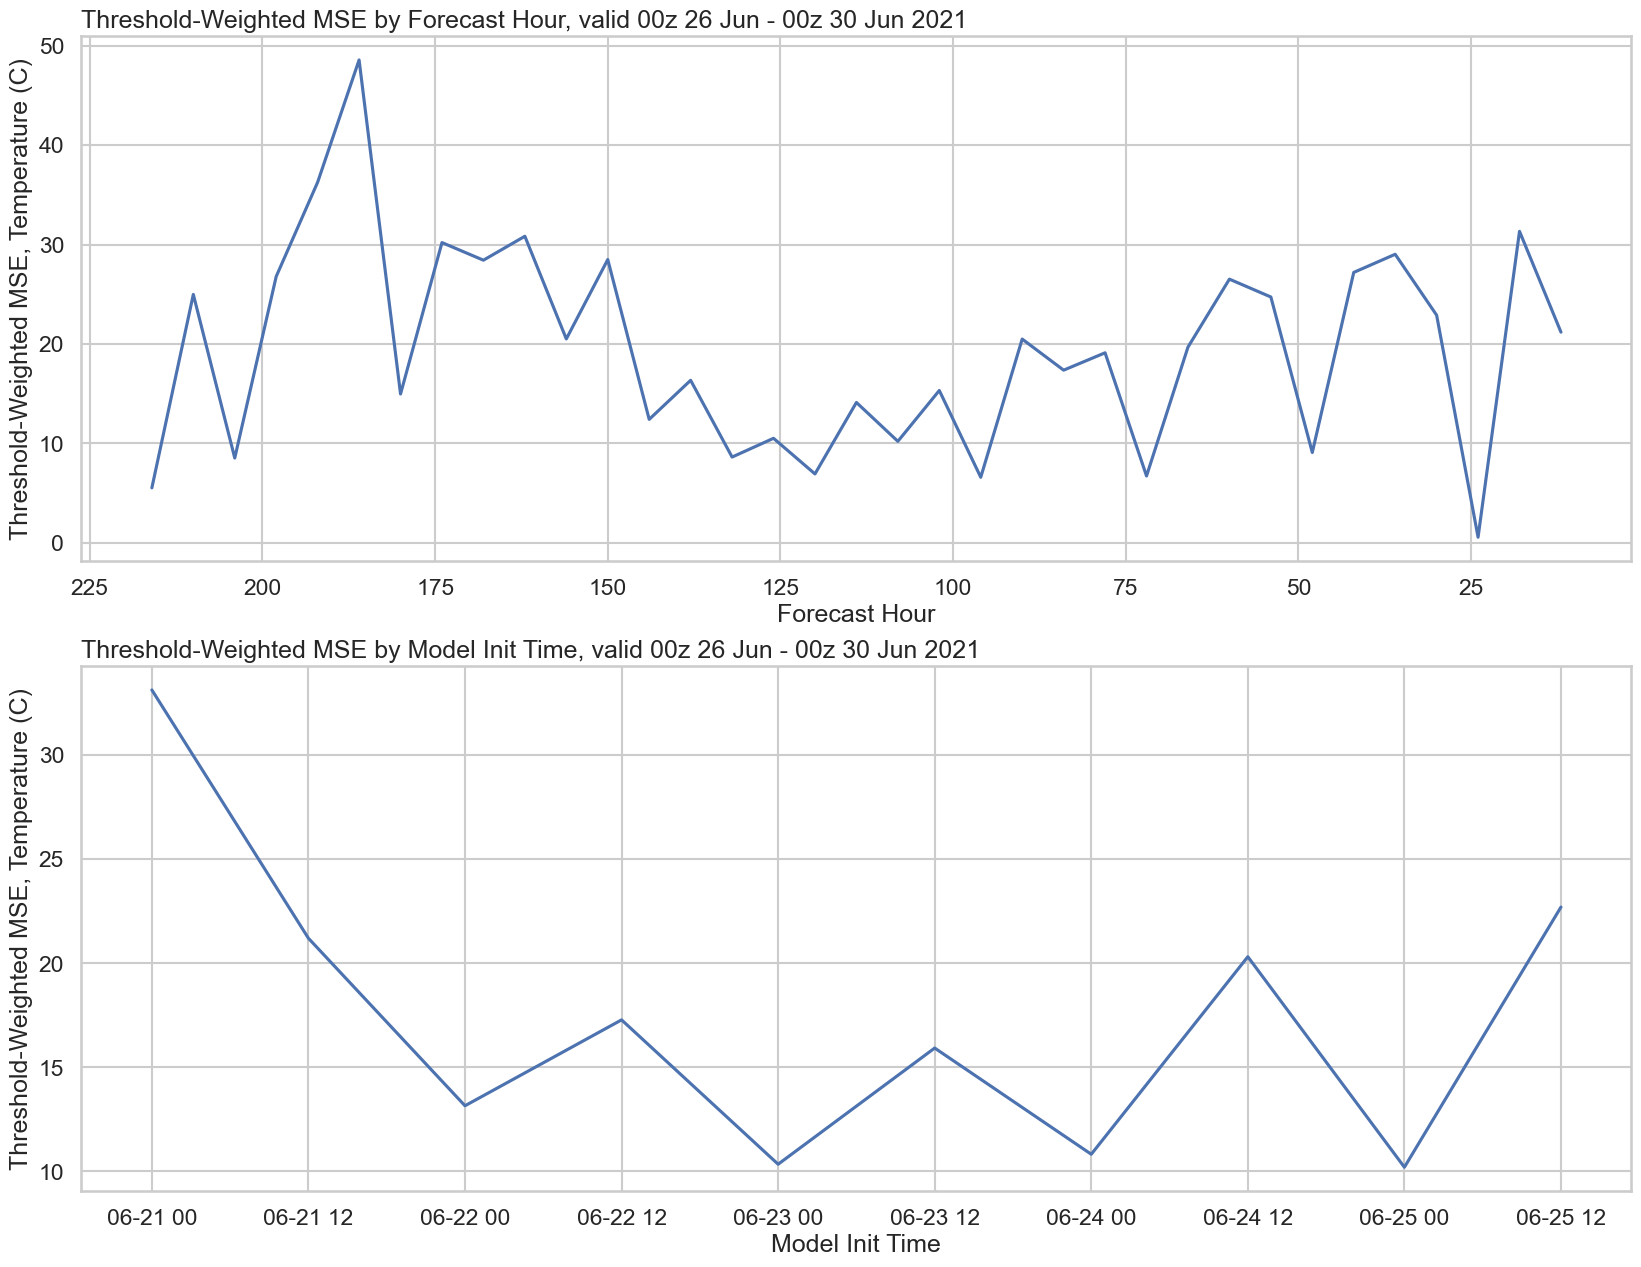

In [226]:
fig, ax = plt.subplots(2,1,figsize=(20,15))
ax[0].plot([n for n in tw_squared_error_by_fhour], [tw_squared_error_by_fhour[n] for n in tw_squared_error_by_fhour])
ax[1].plot([n for n in tw_squared_error_by_init_time], [tw_squared_error_by_init_time[n] for n in tw_squared_error_by_init_time])
ax[0].set_xlabel('Forecast Hour')
ax[0].xaxis.set_inverted(True)

ax[0].set_title('Threshold-Weighted MSE by Forecast Hour, valid 00z 26 Jun - 00z 30 Jun 2021',loc='left')
ax[1].set_title('Threshold-Weighted MSE by Model Init Time, valid 00z 26 Jun - 00z 30 Jun 2021',loc='left')
ax[1].set_xlabel('Model Init Time')

[n.set_ylabel('Threshold-Weighted MSE, Temperature (C)') for n in ax]

In [ ]:
trimmed_init_df[heatwave_time_mask][['t2','tmpc','fhour']].groupby('init_time')

,t2,tmpc
fhour,,
12,25.957367,30.560000
18,20.627441,26.670000
24,23.716125,26.115000
30,24.129257,28.890000
36,24.830017,30.003333
42,23.765076,29.073333
48,25.040199,28.752500
54,25.469612,30.415000
60,25.803858,30.780000


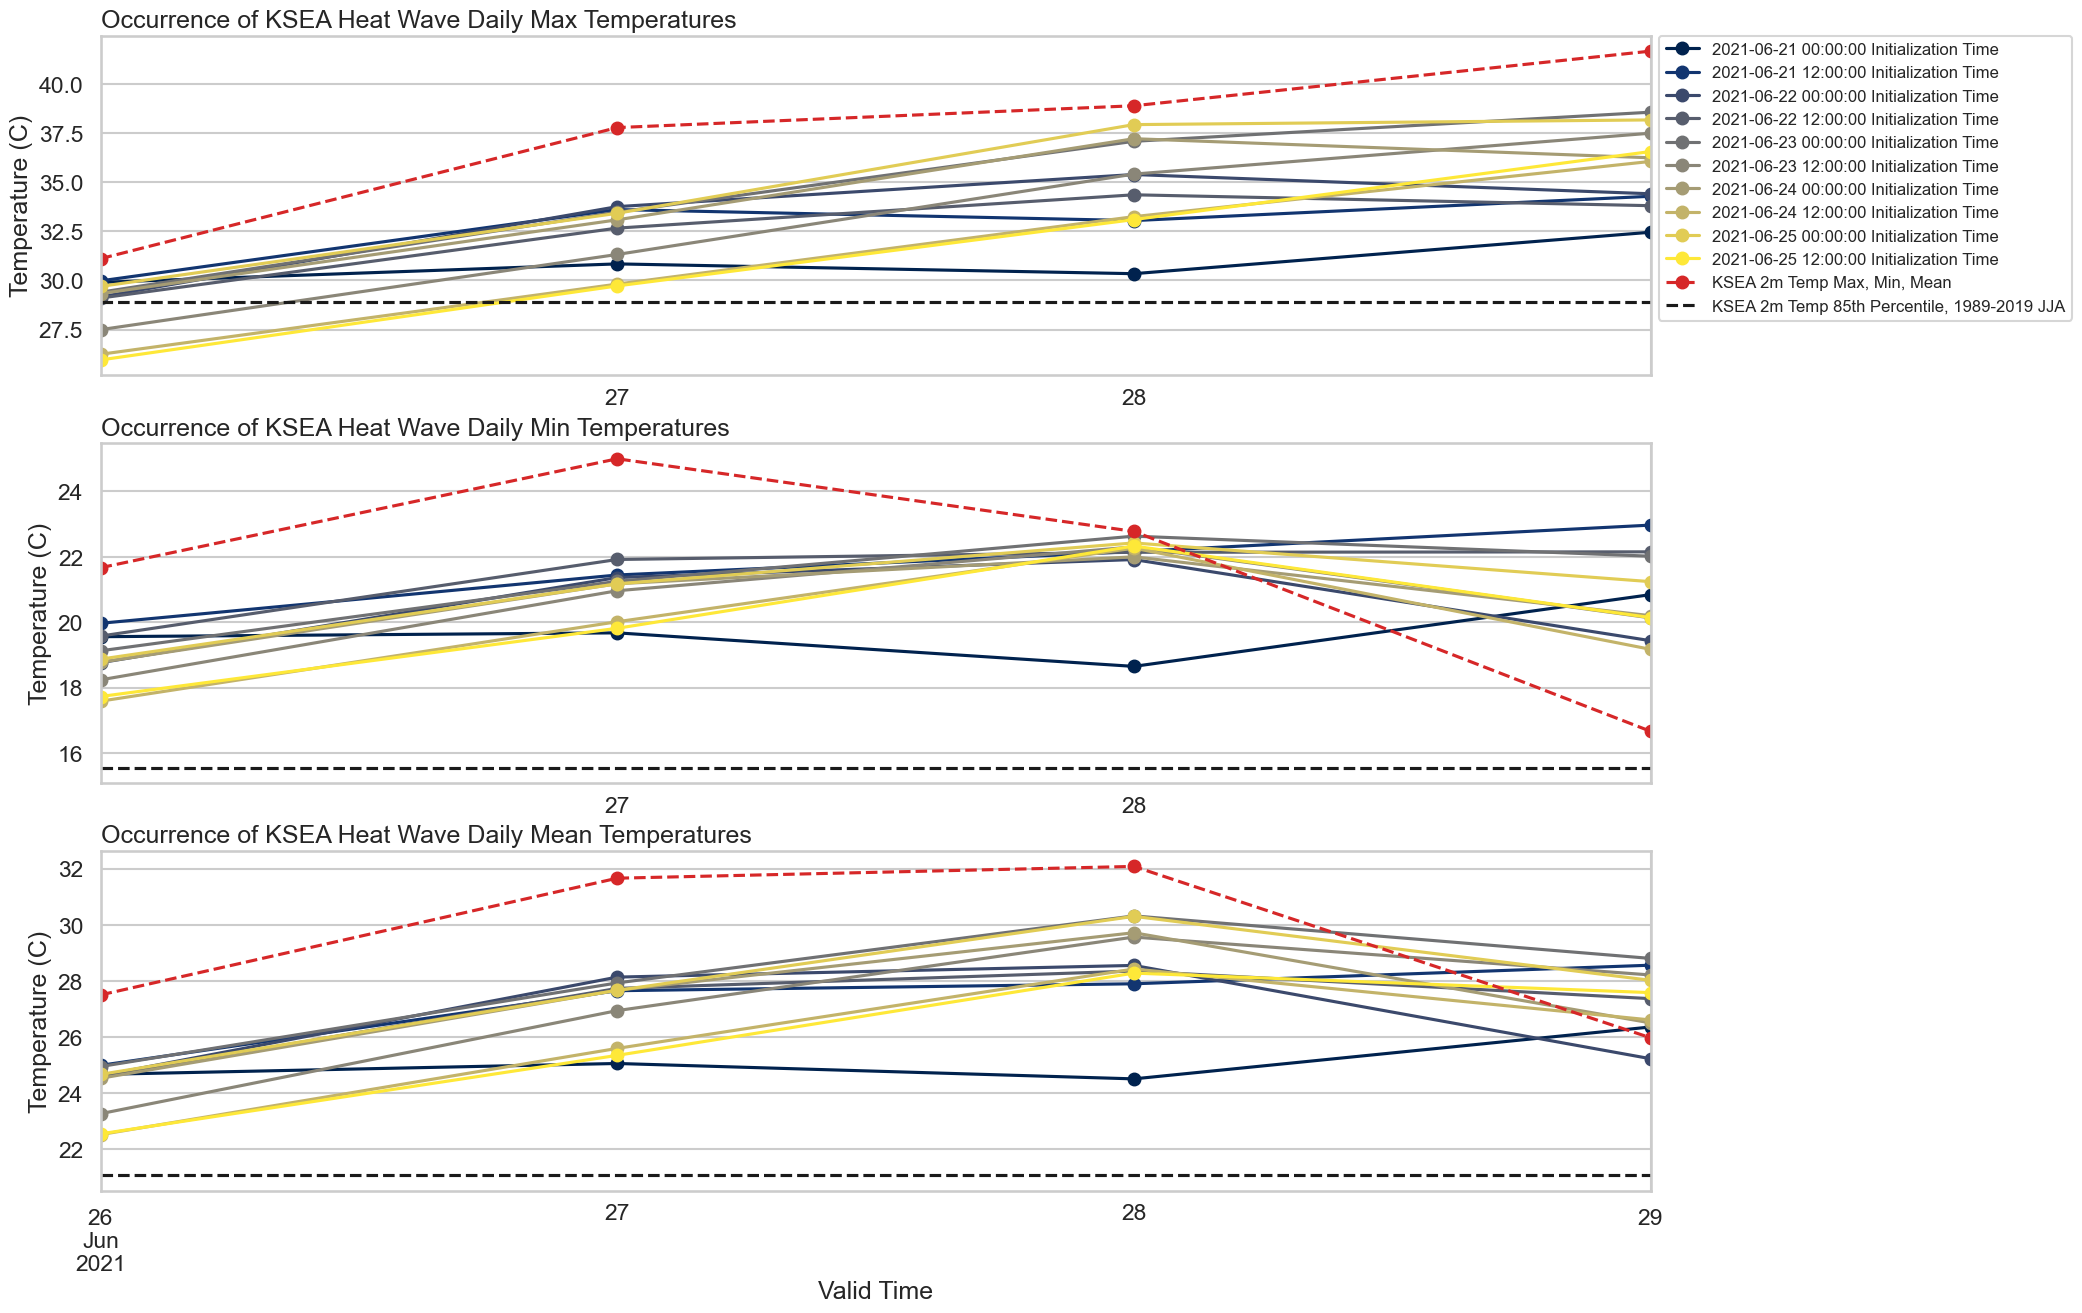

In [ ]:
trimmed_init_df = test_df[test_df['init_time'] < pd.Timestamp('2021-06-26')]
heatwave_time_mask = (trimmed_init_df.index>='2021-06-26') & (trimmed_init_df.index<'2021-06-30')

fig, ax = plt.subplots(3,1, figsize=(20,15))


ax[0].set_title('Occurrence of KSEA Heat Wave Daily Max Temperatures',loc='left')
norm = plt.Normalize(vmin=0, vmax=len(trimmed_init_df[heatwave_time_mask]['init_time'].unique())-1)
cmap = plt.get_cmap('cividis')
for i, n in enumerate(trimmed_init_df[heatwave_time_mask].drop(columns={'key_0','valid'}).groupby('init_time')):
    n[1].resample('D').first().reset_index().plot(kind='line',x='time',y='t2_max',ax=ax[0],marker='o',color=cmap(norm(i)), label=f'{n[0]} Initialization Time')
trimmed_init_df[heatwave_time_mask].drop(columns={'key_0','valid'}).resample('D').first().reset_index().plot(kind='line',x='time',y='tmpc_max',ax=ax[0],marker='o',color='tab:red',ls='--', label='KSEA 2m Temp Max, Min, Mean')
ax[0].axhline(point_obs_dict['KSEA']['max_temp_85th_percentile'],ls='--',c='k',label='KSEA 2m Temp 85th Percentile, 1989-2019 JJA')
ax[0].set_ylabel('Temperature (C)')
ax[0].set_xticklabels([])
ax[0].set_xlabel('')

ax[0].legend(bbox_to_anchor=(1, 1.025),fontsize=12,loc='upper left')

ax[1].set_title('Occurrence of KSEA Heat Wave Daily Min Temperatures',loc='left')
for i, n in enumerate(trimmed_init_df[heatwave_time_mask].drop(columns={'key_0','valid'}).groupby('init_time')):
    n[1].resample('D').first().reset_index().plot(kind='line',x='time',y='t2_min',ax=ax[1],marker='o',color=cmap(norm(i)), label=f'{n[0]} Initialization Time',legend=False)
trimmed_init_df[heatwave_time_mask].drop(columns={'key_0','valid'}).resample('D').first().reset_index().plot(kind='line',x='time',y='tmpc_min',ax=ax[1],marker='o',color='tab:red',ls='--',legend=False)
ax[1].axhline(point_obs_dict['KSEA']['min_temp_85th_percentile'],ls='--',c='k',label='KSEA 2m Temp Min 85th Percentile, 1989-2019 JJA')
ax[1].set_xticklabels([])
ax[1].set_ylabel('Temperature (C)')
ax[1].set_xlabel('')

ax[2].set_title('Occurrence of KSEA Heat Wave Daily Mean Temperatures',loc='left')
for i, n in enumerate(trimmed_init_df[heatwave_time_mask].drop(columns={'key_0','valid'}).groupby('init_time')):
    n[1].resample('D').first().reset_index().plot(kind='line',x='time',y='t2_mean',ax=ax[2],marker='o',color=cmap(norm(i)), label=f'{n[0]} Initialization Time',legend=False)
trimmed_init_df[heatwave_time_mask].drop(columns={'key_0','valid'}).resample('D').first().reset_index().plot(kind='line',x='time',y='tmpc_mean',ax=ax[2],marker='o',color='tab:red',ls='--',legend=False)
ax[2].axhline(point_obs_dict['KSEA']['mean_temp_85th_percentile'],ls='--',c='k',label='KSEA 2m Temp mean 85th Percentile, 1989-2019 JJA')
ax[2].set_ylabel('Temperature (C)')
ax[2].set_xlabel('Valid Time')
# for a in ax:
#     # a.set_xlim(pd.Timestamp('2021-06-25 12:00'), pd.Timestamp('2021-06-30 12:00'))
#     a.set_xbound(pd.Timestamp('2021-06-25 18:00'), pd.Timestamp('2021-06-29T12:00'))
plt.show()

Text(0.0, 1.0, 'Pangu 2m Temperature Errors, KSEA 2021 Jun 26 00z - Jun 30 00z')

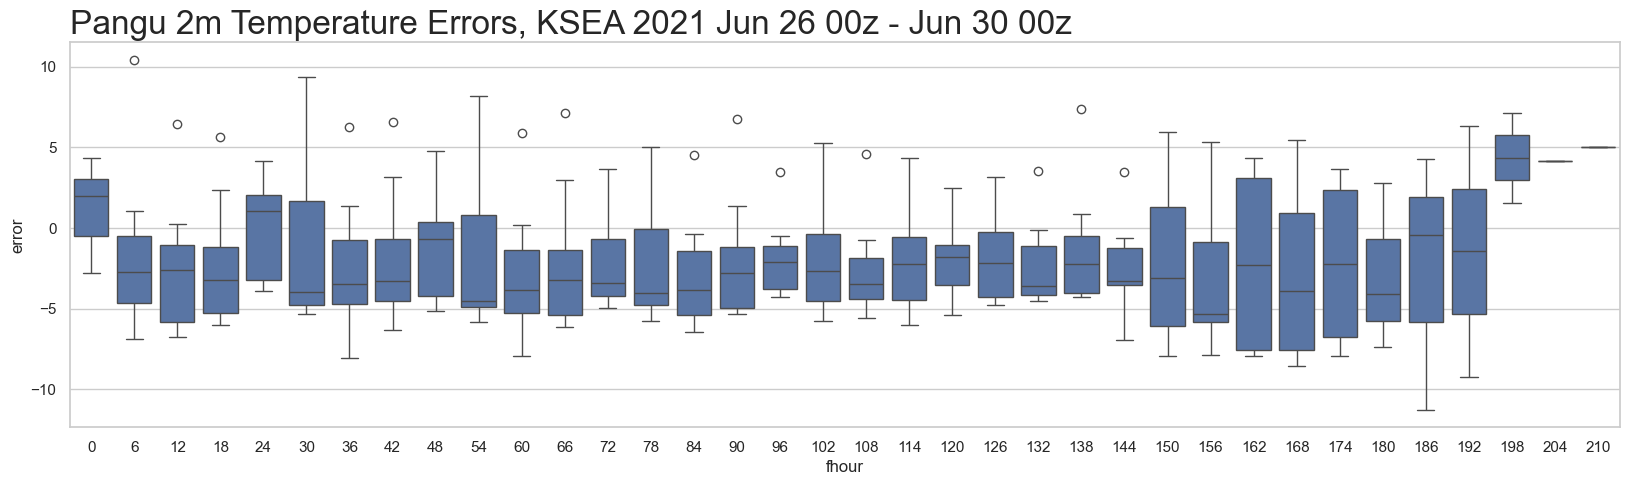

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.set_theme(style='whitegrid')

sns.boxplot(ax=ax[0],data=merged_pangu_ksea_asos_df.loc[heatwave_time_mask],x='fhour',y='error')
ax.set_title('Pangu 2m Temperature Errors, KSEA 2021 Jun 26 00z - Jun 30 00z',loc='left',fontsize=24)

sns.boxplot(ax=ax[0],data=merged_pangu_ksea_asos_df.loc[heatwave_time_mask],x='fhour',y='error')
ax.set_title('Pangu 2m Temperature Errors, KSEA 2021 Jun 26 00z - Jun 30 00z',loc='left',fontsize=24)

# Plot map as test

In [ ]:
fs_ = fsspec.filesystem("reference", fo=json_list[0], ref_storage_args={'skip_instance_cache':True},
                       remote_protocol='gcs', remote_options={'anon':True})
m = fs_.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
ds['t2c'] = ds['t2']-273.15

In [ ]:
# for single axes plot colorbars, use
# divider = make_axes_locatable(ax)
# ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
# fig.add_axes(ax_cb)
# fig.colorbar(output, cax=ax_cb, label='Temperature (C)')

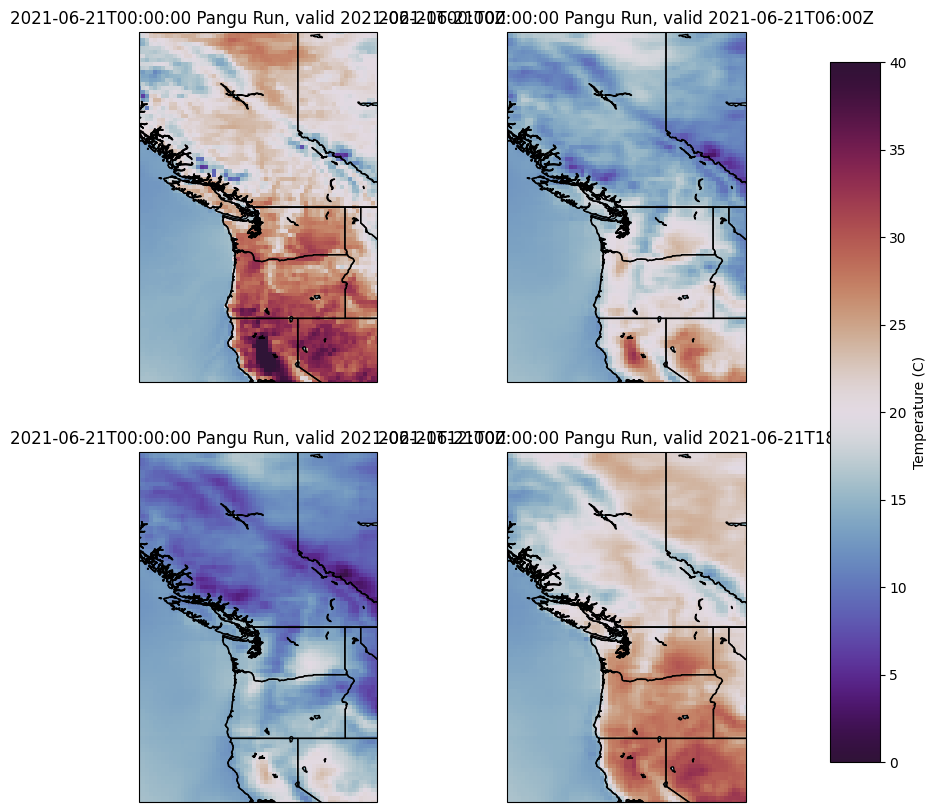

In [ ]:
ds_plot_subset = ds['t2c'].isel(time=slice(0,4))
# Define the extent for the Pacific Northwest
extent = [-130, -115, 38, 60]  # [longitude_min, longitude_max, latitude_min, latitude_max]


# Create the figure and axis with a Cartopy projection
fig, axs = plt.subplots(2,2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs.flat):
    ax.set_extent(extent)

    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.STATES,edgecolor='black')

    # Plot the contourf
    output = ds_plot_subset.isel(time=i).plot(ax=ax, cmap='twilight_shifted', vmin=0, vmax=40, transform=ccrs.PlateCarree(),add_colorbar=False)

    # Add a color bar
    ax.set_title(f"{ds.attrs['initialization_time']} Pangu Run, valid {np.datetime_as_string(ds_plot_subset.isel(time=i).time.values,timezone='UTC',unit='m')}")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(output, cax=cbar_ax,cmap = 'twilight_shifted', label = "Temperature (C)")
# fig.colorbar(output, shrink = 1,ax=axs, orientation='horizontal')
plt.show()

# Load ERA5 and Compare

In [9]:
era5 = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    chunks=None,
    storage_options=dict(token='anon'),
)

In [ ]:
def is_jja(month):
    return (month >= 6) & (month <= 8)

def is_6_hourly(hour):
    return (hour == 0) | (hour == 6) | (hour == 12) | (hour == 18)

era5_climatology = era5[['2m_temperature']].sel(time=slice('1989','2019'))
era5_subset_jja = era5_climatology.sel(time=is_jja(era5_climatology['time.month']))
era5_subset_hours = era5_subset_jja.sel(time=is_6_hourly(era5_subset_jja['time.hour']))
era5_subset_hours.compute()

2024-11-27 11:48:41,727 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "x:\anaconda3\envs\brightband\Lib\site-packages\tornado\websocket.py", line 938, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "x:\anaconda3\envs\brightband\Lib\site-packages\tornado\web.py", line 3301, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "x:\anaconda3\envs\brightband\Lib\site-packages\bokeh\server\views\ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration if necessary")
bokeh.protocol.exceptions.ProtocolError: Token is expired. Configure 

In [20]:
era5_climatology_max = era5_subset_hours.resample({'time':'D'}).max()
era5_climatology_min = era5_subset_hours.resample({'time':'D'}).min()
era5_climatology_mean = era5_subset_hours.resample({'time':'D'}).mean()

In [39]:
era5_climatology_max

<xarray.Dataset> Size: 46GB
Dimensions:         (latitude: 721, longitude: 1440, time: 11049)
Coordinates:
  * latitude        (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * time            (time) datetime64[ns] 88kB 1989-06-01 ... 2019-08-31
Data variables:
    2m_temperature  (time, latitude, longitude) float32 46GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

x:\anaconda3\envs\brightband\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Task exception was never retrieved
future: <Task finished name='Task-2345225' coro=<Client._gather.<locals>.wait() done, defined at x:\anaconda3\envs\brightband\Lib\site-packages\distributed\client.py:2395> exception=AllExit()>
Traceback (most recent call last):
  File "x:\anaconda3\envs\brightband\Lib\site-packages\distributed\client.py", line 2404, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-2345076' coro=<Client._gather.<locals>.wait() done, defined at x:\anaconda3\envs\brightband

KeyboardInterrupt: 

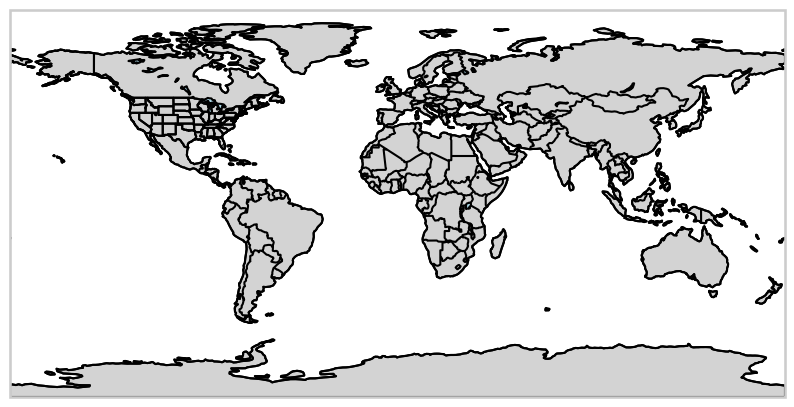

In [40]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# Add map features
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.STATES,edgecolor='black') 
era5_climatology_max['2m_temperature'].quantile(0.85,dim='time').plot(ax=ax,cmap='inferno')
plt.show()

In [10]:
for json_file in json_list:
    fs_ = fsspec.filesystem("reference", fo=json_file, ref_storage_args={'skip_instance_cache':True},
                       remote_protocol='gcs', remote_options={'anon':True})
    m = fs_.get_mapper("")
    ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})

NameError: name 'json_list' is not defined

In [ ]:
era5.sel(time=slice('2021-06-26','2021-06-30'))

<xarray.Dataset> Size: 116GB
Dimensions:                                           (time: 120,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 296B 1 .....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 960B ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 498MB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 498MB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 498MB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 18GB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 498MB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 18GB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 18GB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 18GB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>